In [1]:
import yaml
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os
import seaborn as sns
from datetime import datetime
from scipy.stats import pearsonr
import numpy as np
import math

In [ ]:
data/lchu/hls/vis/400-fair-bs16-2023-08-20_17-19-23
data/lchu/hls/vis/800-fair-bs16-2023-08-20_17-18-52
data/lchu/hls/vis/1600-fair-bs16-2023-08-20_17-19-05
data/lchu/hls/vis/3200-fair-bs16-2023-08-21_16-49-23
data/lchu/hls/vis/6231-fair-bs16-2023-08-21_16-49-34

In [49]:
# Load the YAML file
yaml_file_path = Path("/workspace/data/lchu/hls/jobs/6231-fair-bs16-2023-08-21_16-49-34")  # Replace with the actual path to your YAML file
with open(yaml_file_path, "r") as file:
    yaml_data = yaml.safe_load(file)
training_length = yaml_data["training_length"]
# Access the file path from the YAML data
data_file_path = Path(yaml_data["csv_dir"]) / "chip_stats.csv"
val_cloud_path = Path("/workspace/data/lchu/hls/logs/csv/3200-fair-bs16-2023-08-21_16-49-23/val_cloud_catalog.csv")
save_dir = Path(yaml_data["visualization_dir"])
os.makedirs(save_dir, exist_ok=True)

# Read the .txt file as a CSV using pandas
data_table = pd.read_csv(data_file_path)
val_clouds = pd.read_csv(val_cloud_path)
val_clouds.sort_values(by='fmask_name', inplace=True)

# Display the DataFrame
print(data_table.head())
print(val_clouds.head())

df = pd.concat([data_table.reset_index(drop=True), val_clouds.reset_index(drop=True)], axis=1)
print(df.columns)

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/data/lchu/hls/jobs/6231-fair-bs16-2023-08-21_16-49-34'

In [50]:
df['first_image_date'] = pd.to_datetime(df['first_image_date'])
df['second_image_date'] = pd.to_datetime(df['second_image_date'])
df['third_image_date'] = pd.to_datetime(df['third_image_date'])


# Calculate the difference in days
df['Time Gap'] = (df['third_image_date'] - df['first_image_date']).dt.days
df['Cloud Ratio'] = df['cloud_pct']
df['Overall RMSE'] = np.sqrt(df['Overall MSE'])
df['SSIM Error'] = (1 - df['Overall SSIM']) / df['Cloud Ratio']
print(df.head())
print(df.columns)

KeyError: 'first_image_date'

In [ ]:
columns_to_average = [
    'B02 MSE', 'B03 MSE', 'B04 MSE', 'B05 MSE',
    'B07 MSE', 'B08 MSE', 'B02 MAE', 'B03 MAE',
    'B04 MAE', 'B05 MAE', 'B07 MAE', 'B08 MAE',
    'B02 SSIM', 'B03 SSIM', 'B04 SSIM', 'B05 SSIM',
    'B07 SSIM', 'B08 SSIM'
]
mae_list = ['B02 MAE', 'B03 MAE',
    'B04 MAE', 'B05 MAE', 'B07 MAE', 'B08 MAE']
mae_averages = df[mae_list].mean()
means = [mean / 10000 for mean in [495.7316,  814.1386,  924.5740, 2962.5623, 2640.8833, 1740.3031]]
error = mae_averages / means
print(error)
# Calculate column averages
column_averages = df[columns_to_average].mean()

# Print the calculated averages
print(column_averages)

             Overall SSIM Overall MAE Cloud Ratio  Time Gap
Overall SSIM       1.0***     -0.9***    -0.87***  -0.11***
Overall MAE       -0.9***      1.0***     0.74***   0.21***
Cloud Ratio      -0.87***     0.74***      1.0***     -0.02
Time Gap         -0.11***     0.21***       -0.02    1.0***
              Overall SSIM  Overall MAE  Cloud Ratio  Time Gap
Overall SSIM       1.00000    -0.895110    -0.870650 -0.106540
Overall MAE       -0.89511     1.000000     0.737682  0.210746
Cloud Ratio       -0.87065     0.737682     1.000000 -0.017933
Time Gap          -0.10654     0.210746    -0.017933  1.000000


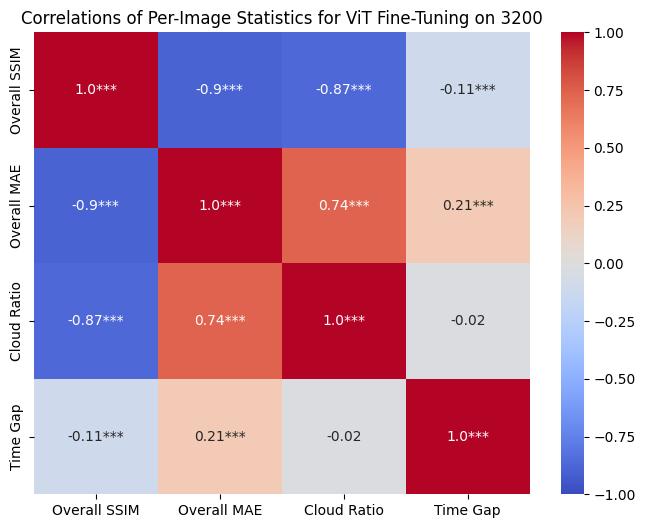

In [51]:
df = df[['Overall SSIM', 'Overall MAE',
       'Cloud Ratio', 'Time Gap']]


rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
significant_correlations = rho.round(2).astype(str) + p
print(significant_correlations)
print(rho)



# Create the heatmap of p-values
plt.figure(figsize=(8, 6))
sns.heatmap(rho, annot=significant_correlations, fmt='', cmap="coolwarm", vmin=-1, vmax=1)  # Format to 3 decimal places
plt.title(f'Correlations of Per-Image Statistics for ViT Fine-Tuning on {training_length}')

plt.savefig(save_dir / 'per_image_correlations.png', format='png')

/tmp/ipykernel_3013/871251530.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


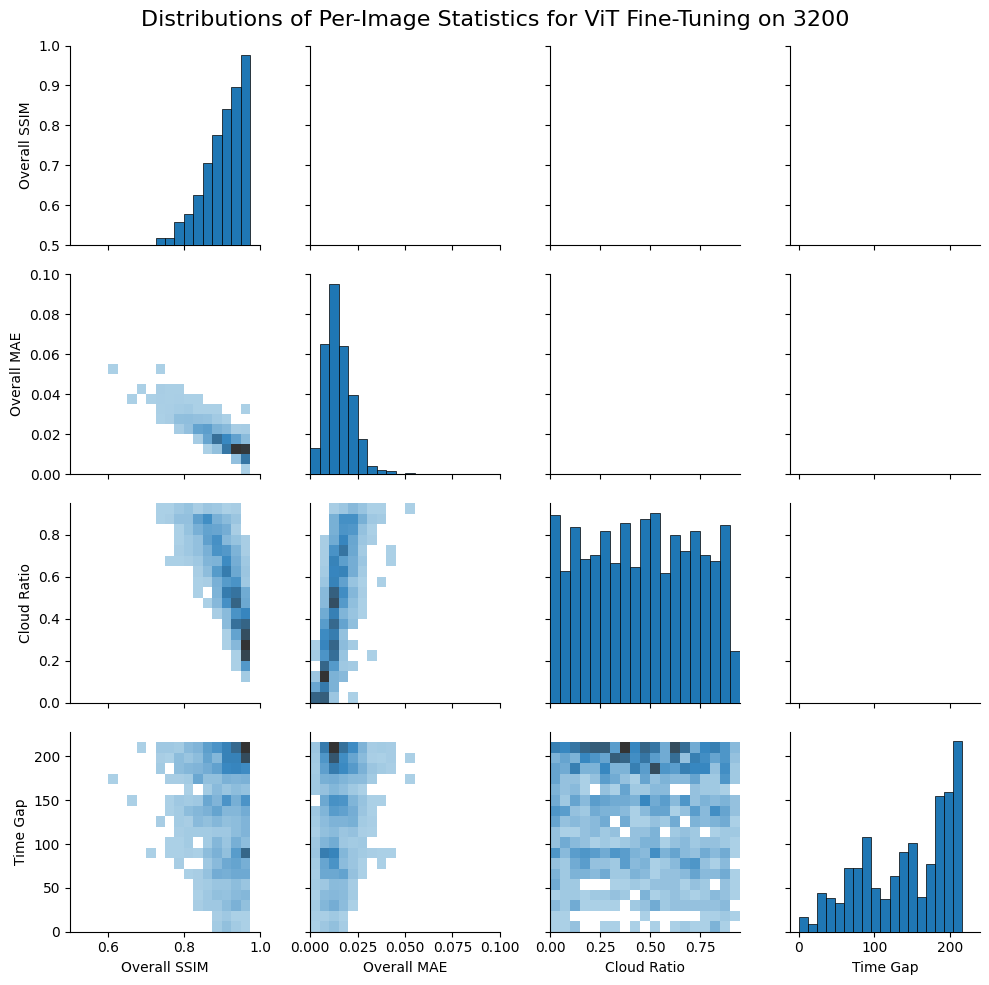

In [52]:
bin_edges = [round(i * 0.05, 2) for i in range(20)]


bins = {'Overall SSIM' : [round(i * 0.025, 3) + 0.5 for i in range(20)],
        'Overall MAE' : [round(i * 0.005, 3) for i in range(20)],
        'Cloud Ratio' : [round(i * 0.05, 3) for i in range(20)],
        'Time Gap' : [round(i * 12, 3) for i in range(20)]}

def myhist(x, **kwargs):
    b = bins[x.name]
    plt.hist(x, bins=b, edgecolor='black', linewidth=0.5, **kwargs)

def mypair(x, y, **kwargs):
    bins_x = bins[x.name]
    bins_y = bins[y.name]
    cmap=sns.color_palette("Blues_d", as_cmap=True)
    plt.hist2d(x, y, bins=[bins_x, bins_y], cmap=cmap, linewidth=0, cmin=1, **kwargs)

df = df[['Overall SSIM', 'Overall MAE', 'Cloud Ratio', 'Time Gap']]
g = sns.PairGrid(df, diag_sharey=False)
g.map_diag(myhist)
g.map_lower(mypair)

g.axes[0,0].set_xlim(0.5,1)
g.axes[0,0].set_ylim(0.5,1)
g.axes[1,1].set_xlim(0,0.1)
g.axes[1,1].set_ylim(0,0.1)

plt.suptitle(f'Distributions of Per-Image Statistics for ViT Fine-Tuning on {training_length}', fontsize=16)
plt.tight_layout()
plt.savefig(save_dir / 'per_image_pairgrid.png', format='png')
